# Community Solar Hardware Recommender

## Overview
Returns hardware recommendations based on a few different goals

### Current Gaps
* filter hardware list, but by what? top 50%? Which is the most important characteristic?
* hardware inneficiencies
* confirm that the NREL model is based off of the weather file and that encompasses overcast chance
* change in cost of electricity from grid (and inflation) over time (see NREL levelized cost calculator
* include participation rate

### Things not included in the model
* Aggregator operational costs are not included here. The results of this study can be used for further research to attempt to design an aggregation service that can function within these parameters

## Psuedo Code

Inputs:
* Location
* Range of PV and Battery options
* Cost estimates
* Network info
* shading on an hourly basis

1) Get hourly irradiance from NREL
2) loop through every possible PV and battery combo and determine:
    * estimated hardware costs
    * estimated annual PV Wh generation (does it get curtailed if it exceeds battery capacity)?
    * maximum automated DR participation (combines battery capacity and SOA during event windows)
    * calculates ROI
3) Remove options that don't break even within 7 years from data set
4) graph all data
5) identify:
    * hardware combination with quickest ROI
    * largest PV system within 8 year ROI
    * largest Battery system within 7 year ROI
    * largest overall system within 7 year ROI
    * system with largest avoided grid consumption
    * system with largest automated DR event participation
    
## Variations to Test

* only best hardware 
    * w to wh
    * $ per wh
* only worst hardware
* afternoon call times

In [561]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import math
from scipy import stats 

In [562]:
myNetwork = 'city hall'

#Max Hardware Sizes
#500 is an estimate for the largest array someone can relatively easily install without a professional
pvMaxW = 500
#2kWh is the largest system FDNY allows without additional beurocracy 
batMaxWh = 2000

shading = .87

#equipment derating -> charge controller efficiency etc
equipDerating = .99

totDerating = equipDerating * shading

### Commercially Available Hardware Data

Here we're interested in understanding modeling what would be representative of commercially available hardware today.

Specifically, we want to identify which characteristics best impact retail price. Because the variables in retail price are vague (i.e. sales, loss-leaders, marketing, etc.), we want to avoid over fitting, so a simple regression or median $/Wh is probably best. The regression is focused more on the relationships between data, so it might better reflect 

Similarly, max PV watts is not purely determined by battery Wh because of design and marketing choices that are not just based on maximum technical ability. (For example, a product line might use the same CC circuitry so the max PV W size is perhaps correlated to the smallest battery Wh within that group of products)

For other characteristics median is best.

In [563]:
# read in hardware data to dataframe
hardware_df = pd.read_csv('data/DER-Hardware-November-LiFePo4-batteriespowerstations-updated-NOV12.csv')

#clean data
hardware_df = hardware_df.drop(columns=['Link','Battery Type','Smart Control','Pass Through Charging',
                                       'Inverter Efficiency','Inverter Watts', 'Warranty Years','Lifespan'])

#filter out product lines that duplicate specs
hardware_productline_df = hardware_df.drop(index=[11,12,13,31,33])

hardware_df.head()

,Make,Model,Battery Wh,Max PV Watt,W to Wh ratio,Min PV Voltage,Max PV Voltage,Max PV Amps,Grid Charge Watts,Retail Price (11/12/2023),Price per Wh,Cycles,DoD
0,Jackery,Explorer 1000 Plus Portable Power Station,1264.64,800,0.632591,NaN,NaN,NaN,NaN,899.0,0.71,4000,70
1,Jackery,Explorer 2000 Plus Portable Power Station,2042.80,1400,0.685334,NaN,NaN,NaN,NaN,1659.0,0.81,4000,70
2,Pecron,Portable Power Station,614.00,400,0.651466,12.0,18.0,7.0,NaN,299.0,0.49,3500,80
3,Pecron,E1500LFP Expandable Power Station,1536.00,800,0.520833,12.0,18.0,7.0,NaN,899.0,0.59,3500,80
4,Pecron,E2000LFP Expandable Portable Power Station,1920.00,1200,0.625000,12.0,18.0,7.0,NaN,899.0,0.47,3500,80


In [564]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(hardware_df.shape[0]))

#hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')


Total Number of Companies: 15
Total Number of Products: 37


In [565]:
hardware_df.keys()

Index(['Make', 'Model', 'Battery Wh', 'Max PV Watt', 'W to Wh ratio',
       'Min PV Voltage', 'Max PV Voltage', 'Max PV Amps', 'Grid Charge Watts',
       'Retail Price (11/12/2023)', 'Price per Wh', 'Cycles', 'DoD'],
      dtype='object')

<AxesSubplot:title={'center':'Impact of Wh on Price w/ Raw Data'}, xlabel='Battery Wh', ylabel='Retail Price (11/12/2023)'>

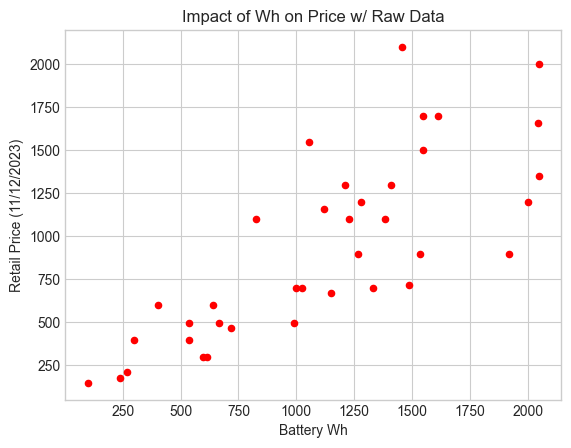

In [566]:
hardware_df.plot(kind = 'scatter', x = 'Battery Wh', y = 'Retail Price (11/12/2023)', c='red',colormap='viridis', title="Impact of Wh on Price w/ Raw Data")

<AxesSubplot:title={'center':'Impact of W on Price w/ Raw Data'}, xlabel='Max PV Watt', ylabel='Retail Price (11/12/2023)'>

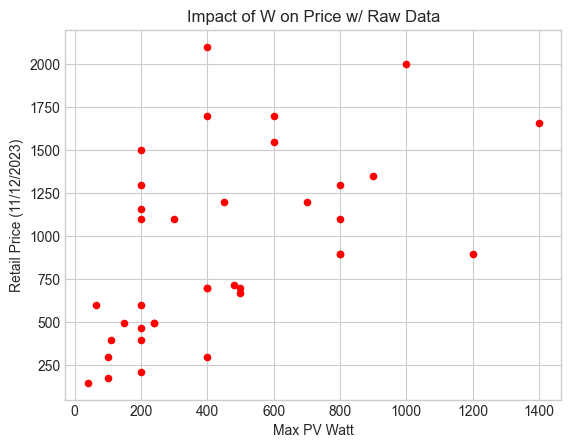

In [567]:
hardware_df.plot(kind = 'scatter', x = 'Max PV Watt', y = 'Retail Price (11/12/2023)', c='red',colormap='viridis',title="Impact of W on Price w/ Raw Data")

<AxesSubplot:title={'center':'Impact of Wh on W w/ Raw Data'}, xlabel='Battery Wh', ylabel='Max PV Watt'>

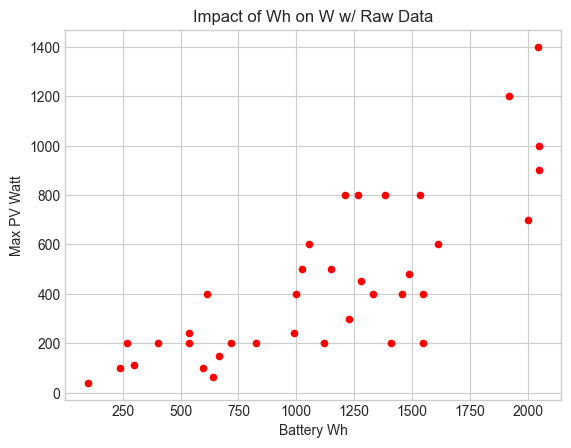

In [568]:
hardware_df.plot(kind = 'scatter', x = 'Battery Wh', y = 'Max PV Watt', c='red',colormap='viridis',title="Impact of Wh on W w/ Raw Data")

In [569]:
#Pearson Correlation Matrix

hardware_df.corr()

# Note:
# that correlations between characteristics that have the same variables or a direct relationship
# (like PV watts to W/Wh Ratio) should be ignored.


,Battery Wh,Max PV Watt,W to Wh ratio,Min PV Voltage,Max PV Voltage,Max PV Amps,Grid Charge Watts,Retail Price (11/12/2023),Price per Wh,Cycles,DoD
Battery Wh,1.000000,0.785440,0.070877,0.499144,0.491794,0.276028,NaN,0.785937,-0.237409,0.371817,-0.238154
Max PV Watt,0.785440,1.000000,0.614718,0.227059,0.320854,-0.023698,NaN,0.538631,-0.243247,0.283201,-0.478243
W to Wh ratio,0.070877,0.614718,1.000000,-0.066965,0.101243,-0.342138,NaN,-0.034914,-0.084242,-0.025860,-0.374797
Min PV Voltage,0.499144,0.227059,-0.066965,1.000000,0.634889,0.576329,NaN,0.449562,0.015622,0.449057,NaN
Max PV Voltage,0.491794,0.320854,0.101243,0.634889,1.000000,0.341082,NaN,0.353638,0.001241,-0.021519,NaN
Max PV Amps,0.276028,-0.023698,-0.342138,0.576329,0.341082,1.000000,NaN,0.518227,0.399429,0.472791,NaN
Grid Charge Watts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Retail Price (11/12/2023),0.785937,0.538631,-0.034914,0.449562,0.353638,0.518227,NaN,1.000000,0.328382,0.215465,-0.162171
Price per Wh,-0.237409,-0.243247,-0.084242,0.015622,0.001241,0.399429,NaN,0.328382,1.000000,-0.278419,0.086207
Cycles,0.371817,0.283201,-0.025860,0.449057,-0.021519,0.472791,NaN,0.215465,-0.278419,1.000000,-0.259523


In [570]:
#which variables have the strongest correlation to price?

print('Notable Correlations:')
print("Bat Wh to Retail Price: " + str(hardware_df['Battery Wh'].corr(hardware_df['Retail Price (11/12/2023)'])))

print("Max PV Watts to Retail price: " + str(hardware_df['Max PV Watt'].corr(hardware_df['Retail Price (11/12/2023)'])))

print("Bat Wh to Max PV Watts: " + str(hardware_df['Battery Wh'].corr(hardware_df['Max PV Watt'])))


Notable Correlations:
Bat Wh to Retail Price: 0.7859369880240203
Max PV Watts to Retail price: 0.5386313160811268
Bat Wh to Max PV Watts: 0.7854398212831589


0.7504101468655603
92.35495197694922
0.7859369880240202
8.251898087426695e-09
0.0997885769602612


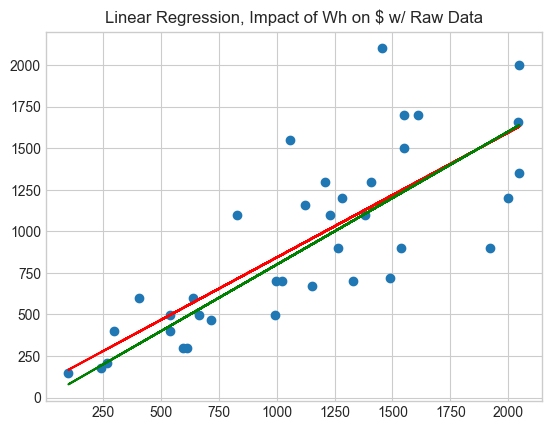

In [571]:
pSlope, pIntercept, pR, pP, pStd_err = stats.linregress(hardware_df['Battery Wh'],hardware_df['Retail Price (11/12/2023)'])
print(pSlope)
print(pIntercept)
print(pR)
print(pP)
print(pStd_err)


def powerStationPrice(x):
  return pSlope * x + pIntercept 

priceModel = list(map(powerStationPrice, hardware_df['Battery Wh']))

plt.scatter(hardware_df['Battery Wh'],hardware_df['Retail Price (11/12/2023)'])


plt.plot(hardware_df['Battery Wh'], priceModel, color='r')

plt.plot(hardware_df['Battery Wh'],hardware_df['Battery Wh'] * hardware_df['Price per Wh'].median(), color='g')

plt.title("Linear Regression, Impact of Wh on $ w/ Raw Data", fontdict=None, loc='center', pad=None)
plt.show()



In [572]:
print(powerStationPrice(100))

167.39596666350525


In [573]:
#filtering is NOT being used

# # filter hardware list to remove outliers

# #remove rows with W to Wh ratios < .25
# fhardware_df = hardware_df[(hardware_df['Cycles'] >= 3000)]

# #remove rows with W to Wh ratios < .25
# fhardware_df = hardware_df[(hardware_df['W to Wh ratio'] > .2)]

# #remove rows with price per Wh > 1.0
# fhardware_df = fhardware_df[(fhardware_df['Price per Wh'] <= 1.2)]

fhardware_df = fhardware_df[(fhardware_df['Max PV Watt'] < 1000)]

# # data snapshot
# print('Total Number of Companies: ' + str(fhardware_df.drop_duplicates(subset=['Make']).shape[0]))
# print('Total Number of Products: ' + str(fhardware_df.shape[0]))

fhardware_df = hardware_df

0.4725352573270246
-80.08599981862284
0.785439821283159
8.556996963787124e-09
0.06294111751514174


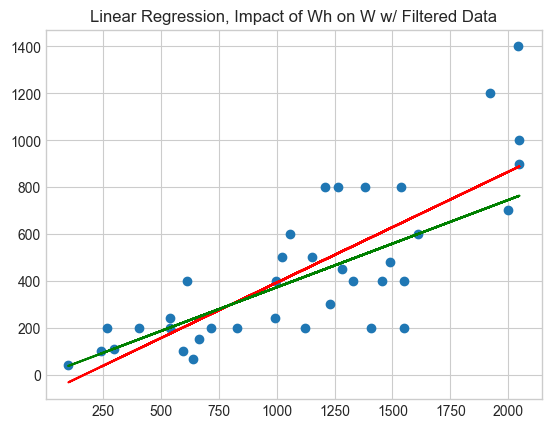

-32.832474085920374

In [574]:
wSlope, wIntercept, wR, wP, wStd_err = stats.linregress(fhardware_df['Battery Wh'],fhardware_df['Max PV Watt'])
print(wSlope)
print(wIntercept)
print(wR)
print(wP)
print(wStd_err)


#input battery Wh -> outputs max PV Watts
def maxPVWatts(x):
  return wSlope * x + intercept 

maxPVWattsModel = list(map(maxPVWatts, fhardware_df['Battery Wh']))
plt.scatter(fhardware_df['Battery Wh'],fhardware_df['Max PV Watt'])


plt.plot(fhardware_df['Battery Wh'], maxPVWattsModel,color='r')

plt.plot(fhardware_df['Battery Wh'], fhardware_df['Battery Wh'] * fhardware_df['W to Wh ratio'].median(),color='g')

plt.title("Linear Regression, Impact of Wh on W w/ Filtered Data", fontdict=None, loc='center', pad=None)


plt.show()

maxPVWatts(100)


0.5081311600166213
-96.37350001804612
0.83033982196181
4.13290822001855e-09
0.062260866047445705
0.40052071300000003


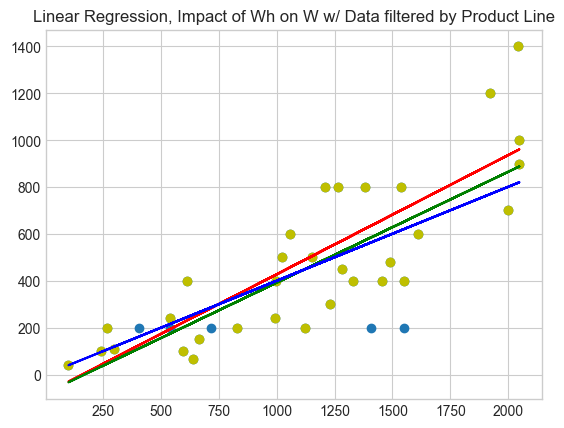

-29.272883816960707

In [575]:

wSlope, wIntercept, wR, wP, wStd_err = stats.linregress(hardware_productline_df['Battery Wh'],hardware_productline_df ['Max PV Watt'])

print(wSlope)
print(wIntercept)
print(wR)
print(wP)
print(wStd_err)


#input battery Wh -> outputs max PV Watts
def maxPVWatts(x):
  return wSlope * x + intercept 


maxPVWattsModelF = list(map(maxPVWatts, hardware_productline_df['Battery Wh']))
plt.scatter(hardware_df['Battery Wh'],hardware_df['Max PV Watt'])
plt.scatter(hardware_productline_df['Battery Wh'],hardware_productline_df['Max PV Watt'], color='y')


plt.plot(hardware_productline_df['Battery Wh'], maxPVWattsModelF,color='r')

plt.plot(hardware_df['Battery Wh'], maxPVWattsModel,color='g')

mHf = hardware_productline_df['W to Wh ratio'].median()
print(mHf)

plt.plot(hardware_productline_df['Battery Wh'], hardware_productline_df['Battery Wh'] * mHf,color='b')

plt.title("Linear Regression, Impact of Wh on W w/ Data filtered by Product Line", fontdict=None, loc='center', pad=None)


plt.show()

maxPVWatts(100)


In [576]:
#for pricing correlation coeficients and linear regression is used because it provides a clearer picture of the impact of characteristics on price (rather than simply median $ per Wh)

#median is used to characteristics that include outliers and dont have a strong correllation to other characteristics
# this includes DoD and Cycles

#80% depth of discharge for LiFePO4 batteries
LiFePOdod = fhardware_df['DoD'].median()*.01
print("Median LiFePO4 DoD: " + str(LiFePOdod))

medBatCycles = round(fhardware_df['Cycles'].median())
eol = medBatCycles / 365

print('Median battery cycles: ' + str(medBatCycles) + " (" + str(round(eol/.01)*.01) + " years)")

# check against list of hardware
# note: inv_eff' must be between 90 and 99.5 for PV Watts API
inverterEfficiency = .9

# check against list of hardware
# not currently used in model
gridChargingEfficiency = .96

#battery W to Wh ratio
#should this be a regression too???
batPVcapacity = fhardware_df['W to Wh ratio'].median()
print('W to Wh median: ' + str(batPVcapacity))

batteryDollarPerWh = math.floor(fhardware_df['Price per Wh'].median()*100)*.01
print('$ per Wh median: ' + str(batteryDollarPerWh) + " dollars for 1 Wh")

Median LiFePO4 DoD: 0.8
Median battery cycles: 3100 (8.49 years)
W to Wh median: 0.3724394786
$ per Wh median: 0.8 dollars for 1 Wh


### Con Ed Network Data

In [577]:
# read in hardware data to dataframe

networks_df = pd.read_csv('data/conEdNetworks2023-cleaned.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,14:00,18:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,1
4,bronx,southeast bronx,16:00,20:00,2


In [578]:
#retrieve network info

networkInfo = networks_df.loc[networks_df['network']== myNetwork]

print(networkInfo)

tier = networkInfo['tier'].iloc[0]
borough = networkInfo['borough'].iloc[0]

startTime =int(networkInfo['start time'].iloc[0].split(":")[0])

      borough    network start time end time  tier
23  manhattan  city hall      11:00    15:00     1


In [579]:
#DR variables


#tier 2 networks pay at a higher rate
if tier == 1:
    DLRPratePerkW = 18
else:
    DLRPratePerkW = 25

print("DLRP rate: " + str(DLRPratePerkW))

#westchester and staten island pay at a lower rate
if borough not in ['westchester','staten island']:
    CSRPratePerkW = 18
else:
    CSRPratePerkW = 6

print("CSRP rate: " + str(CSRPratePerkW))

#performance rates aren't currently used in this model
CSRPperfRatePerkW = 1
DLRPperfRatePerkW = 1

#this is the monthly reservation payment
totDRratePerkW = CSRPratePerkW + DLRPratePerkW

DLRP rate: 18
CSRP rate: 18


In [580]:
#PV Installation Details
lat = 40.7128
long = 74.0060

#seasonal tilt options: summer, winter, average
season = 'summer'


In [581]:
 def pvWattsRequest(lat, season):
        
    if season == 'summer':
        s = -15
    elif season == 'winter':
        s = 15
    else:
        s = 0
        
    # api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#request-url
    nAzimuth = str(170); #cardinal direction
    nCapkW = str(.05); #nameplate capacity minimum 0.05*
    nLat = str(lat); #latitude
    nTilt = str(lat + s); #priotized for summer
    nLosses = str(shading * equipDerating); #derating*
    nInvEff = str(inverterEfficiency * 100); #inverter efficiency*
    nBorough = 'manhattan' #this data should come from the network list ultimately
    nTimeframe = 'hourly'
    nrelKey = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'
    getURL = 'https://developer.nrel.gov/api/pvwatts/v8.json?api_key=' + nrelKey + '&azimuth=' + nAzimuth+'&system_capacity=' + nCapkW +'&losses=' + nLosses +'&array_type=1&module_type=0&inv_eff=' + nInvEff + '&tilt=' +  nTilt +'&address=' + nBorough +',ny&timeframe=' + nTimeframe

    print(getURL)
    return getURL

#we care about hourly plane of array irradiance (POA)
# we can also get hourly DC output, but we'll quickly exceed the 1000 calls an hour max...
# *doesn't impact POA

nrelData = requests.get(pvWattsRequest(lat, season)).json()['outputs']
print(nrelData)

https://developer.nrel.gov/api/pvwatts/v8.json?api_key=oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT&azimuth=170&system_capacity=0.05&losses=0.8613&array_type=1&module_type=0&inv_eff=90.0&tilt=25.7128&address=manhattan,ny&timeframe=hourly
{'ac_monthly': [4.592319721045637, 5.158067502473336, 6.113334154000804, 6.768028355373083, 7.271783713734, 7.327661524165989, 7.550572709158877, 6.984106194448626, 6.367169061436878, 5.242806991425379, 4.028851006247755, 3.697799296488634], 'poa_monthly': [98.61403650172664, 112.9607077624791, 139.6171340868954, 156.8364403526696, 174.2376350850779, 179.4767476622332, 187.7095021228868, 174.0208174800289, 154.0629227619962, 120.6265612681154, 89.59338237140902, 79.74561766761994], 'solrad_monthly': [3.181097951668602, 4.03431099151711, 4.503778518932108, 5.227881345088987, 5.620568873712189, 5.982558255407772, 6.055145229770541, 5.613574757420287, 5.135430758733207, 3.891179395745657, 2.986446079046968, 2.572439279600643], 'dc_monthly': [5.121369601671145

In [582]:
#Annual PV Production w/ 50W module

print('Estimated annual AC production with 50W module (they are all different):')

#multiply this by PV module size
# DC output = annual daily sun hour average * 365 days * cc efficiency * shade losses * module W
# AC output = DC output * inverter efficiency
print('ac_annual kW NREL: ' + str(nrelData['ac_annual']))

dailyAvgRad = nrelData['solrad_annual']

#this is what we use when we calculate all our options...
dcOutputFactors = dailyAvgRad * 365 * equipDerating * shading

#convert to kW
print('ac annual kW calculated from annual average radiation: ' + str(dcOutputFactors * 50 * .001 * inverterEfficiency))

#yet another way to calculate annaul AC output
print('ac annual kW calculated from predicted monthly DC output:' + str(sum(nrelData['dc_monthly'])*inverterEfficiency))

hourlyPOA = nrelData['poa']
hourlyDC = nrelData['dc']

#print(hourlyPOA)

Estimated annual AC production with 50W module (they are all different):
ac_annual kW NREL: 71.10250022999911
ac annual kW calculated from annual average radiation: 64.60916041195973
ac annual kW calculated from predicted monthly DC output:71.50950783557441


In [583]:
# GRID ELECTRICITY COSTS
def avoidedUtilityCosts(generatedkWAC):
    supplyChargeDollarsPerkWh = .09453
    deliveryChargeDollarsPerkWh = .15653
    systemBenefitChargeDollarsPerkWh = .00520
    salesTax = .045
    gridDollarPerkW = (supplyChargeDollarsPerkWh + deliveryChargeDollarsPerkWh + systemBenefitChargeDollarsPerkWh) * (1 + salesTax)
    #print("Con Ed $ per kWh = " + str(gridDollarPerkW))

    annualAvoidedCosts = generatedkWAC * gridDollarPerkW
    
    return annualAvoidedCosts

In [584]:
# HARDWARE COSTS

'''
I'm looking levelized cost - see NREL's report
'''
#variable costs
pvDollarPerW = 1.0 
mountDollarPerW = .4

#fixed costs
bosCost = 10 #bos includes cables, insulation when bringing cables in probably via window
smartController = 100
operatingCosts = 0 #DR aggregation operator costs are not considered here. 
fixedHardwareCosts = bosCost + smartController + operatingCosts

def hardwareCosts(pvW, batWh):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    # average cost of PV modules per kW
    
    variableCosts = powerStationPrice(batWh) + (pvW * (pvDollarPerW + mountDollarPerW))

    #fixed costs
    bosCost = 10 #bos includes cables, insulation when bringing cables in probably via window
    smartController = 100
    operatingCosts = 0 #DR aggregation operator costs are not considered here. 
    fixedHardwareCosts = bosCost + smartController + operatingCosts

    c = fixedHardwareCosts + variableCosts
    return c

print(hardwareCosts(100, 500))

#this is for testing existing battery systems with this model
def hardwareCostsFixedBattery(pvW):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    # average cost of PV modules per kW

    variableCosts = (pvW * (pvDollarPerW + mountDollarPerW))

    

    c = fixedHardwareCosts + variableCosts
    return c

print(hardwareCostsFixedBattery(100))


717.5600254097294
250.0


In [585]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts
def maxDRParticipation(batWh, pvW):
    batteryACOutput = batWh * LiFePOdod * inverterEfficiency * .25
    
    runningTot = 0

    #days in the months May - September
    #daysInMonth = [31,30,31,31,30]
    
    #returns average PV generated for all window hours
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    for d in range(121, 274):
        drEventWindowPOA = 0
        drEventDCWh = 0
        for e in range(startTime,startTime + 4):
            #POA for 1 hour during the event window
            drHour = ((d-1)*24)+e
            #drEventWindowPOA = drEventWindowPOA + hourlyPOA[drHour]
            #this gets scaled because its based on a 50W module
            drEventDCWh = drEventDCWh + (hourlyDC[drHour] * (pvW/50))
        
        #this is average to an hourly basis NOT the total production during the event
        runningTot = runningTot + (drEventDCWh/4)
        
        '''
        print((drEventWindowPOA/1000)*pvW * totDerating)
        print(drEventDCWh)
        print('')
        '''
    
    numDays = 274-121
    avgEventPVWhAC = (runningTot/numDays) * inverterEfficiency
    #print(avgEventPVWhAC)
    return avgEventPVWhAC + batteryACOutput

maxDRParticipation(1000, 500) * .001 * 36 * 5

79.74308647058822

In [586]:
'''
maximum amount of DR participation based on sum of:
battery capacity (assumes battery is full at start of DR event)
PV generation during event
'''
'''
maxAutoParticipation= (batterykWh * .25) + (pvWatts * eventSunHours * derating)
maxAutoDRGross = maxAutoParticipation * (CSRPratePerkW + DLRPratePerkW)

maxAvoidedEnergyConsumption = annualPVWatts

'''

data = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[]
}


#battery watt hour loop 50 - 2000 incrementing by 50
for b in range(1,int(batMaxWh / 50)+1):
    bWh = b * 50
    
    maxPV = min(bWh * batPVcapacity, pvMaxW)
    #pv watts loop 50-500 incrementing by 10
    for p in range(1,int(maxPV / 10)+1):
        
        pW = p * 10
        #print(p * 10)
        
        #PV Watts
        data['pvW'].append(pW)
        #Battert Watt Hours
        data['batWh'].append(bWh)
        #Hardware Costs in Dollars
        hC = hardwareCosts(pW,bWh)
        data['hardwareDollars'].append(hC)
        #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
        pvDCkWh = dcOutputFactors * .001 * pW
        data['annualPVkWh'].append(pvDCkWh)
        #Annual PV generation converted to AC
        pvACkWh = pvDCkWh * inverterEfficiency
        data['annualPVkWhAC'].append(pvACkWh)
        #total annual avoided grid consumption i.e. AC solar generation
        avoidedCosts = avoidedUtilityCosts(pvACkWh)
        data['avoidedGridCosts'].append(avoidedCosts)
        # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  
        maxParW = maxDRParticipation(bWh,pW)
        data['maxAutoParticipation'].append(maxParW)
        # minimum participants in aggregation if using homogenous systems
        data['minParticipants'].append(math.ceil(50000 / maxParW))
        #monthly income from DR participation
        drInc = (maxParW* 0.001 * totDRratePerkW)
        data['drInc'].append(drInc)
        #annual income from DR participation
        data['drIncAnn'].append(drInc * 5)
        #annual income
        inc = avoidedCosts + (drInc * 5)
        data['annualIncome'].append(inc)
        data['roi'].append(hC/inc)

#load data into a DataFrame object:
df = pd.DataFrame(data)

print(str(df.shape[0])+ ' total hardware combinations generated')

print(df.head())
print('--------------------------------------------------------')
print(df.tail())

1340 total hardware combinations generated
   pvW  batWh  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   10     50       253.875459    14.357591      12.921832   
1   10    100       291.395967    14.357591      12.921832   
2   20    100       305.395967    28.715182      25.843664   
3   30    100       319.395967    43.072774      38.765496   
4   10    150       328.916474    14.357591      12.921832   

   maxAutoParticipation  minParticipants  annualIncome        roi  \
0             14.260343             3507      6.027221  42.121478   
1             23.260343             2150      7.647221  38.104818   
2             28.520686             1754     12.054442  25.334724   
3             33.781029             1481     16.461663  19.402412   
4             32.260343             1550      9.267221  35.492460   

   avoidedGridCosts     drInc  drIncAnn  
0          3.460359  0.513372  2.566862  
1          3.460359  0.837372  4.186862  
2          6.920719  1.026745  5.133723  
3

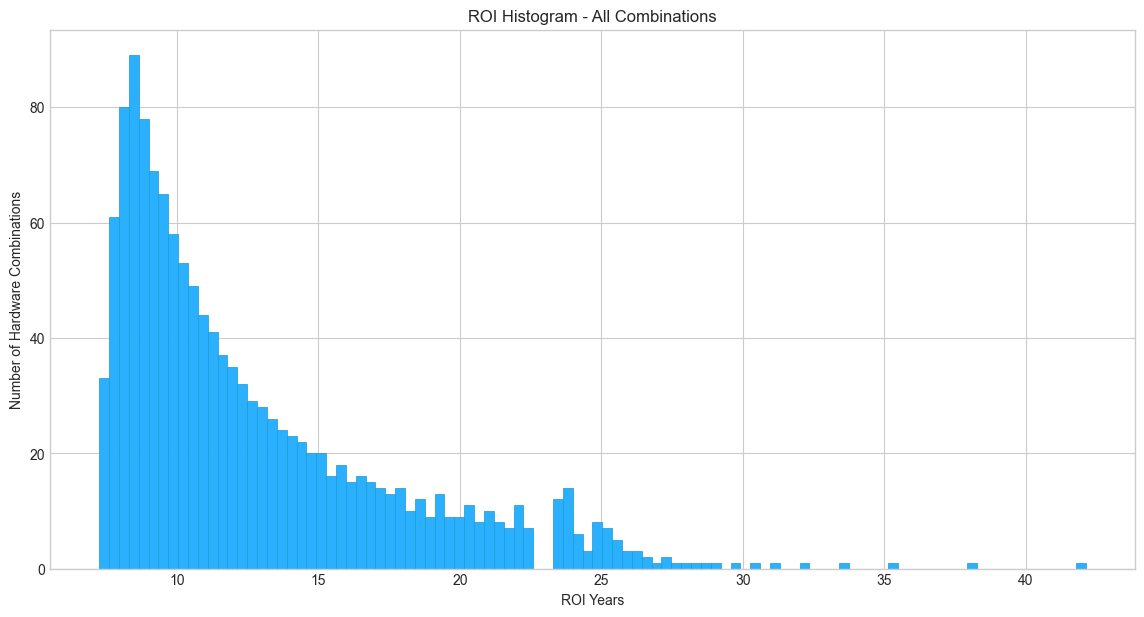

In [587]:
#ROI histogram

#n, bins, patches = plt.hist(df['roi'], 100, density=False, facecolor='g', alpha=0.75)

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df['roi'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('ROI Histogram - All Combinations') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

#style source: https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca

223 hardware combinations with favorable ROI


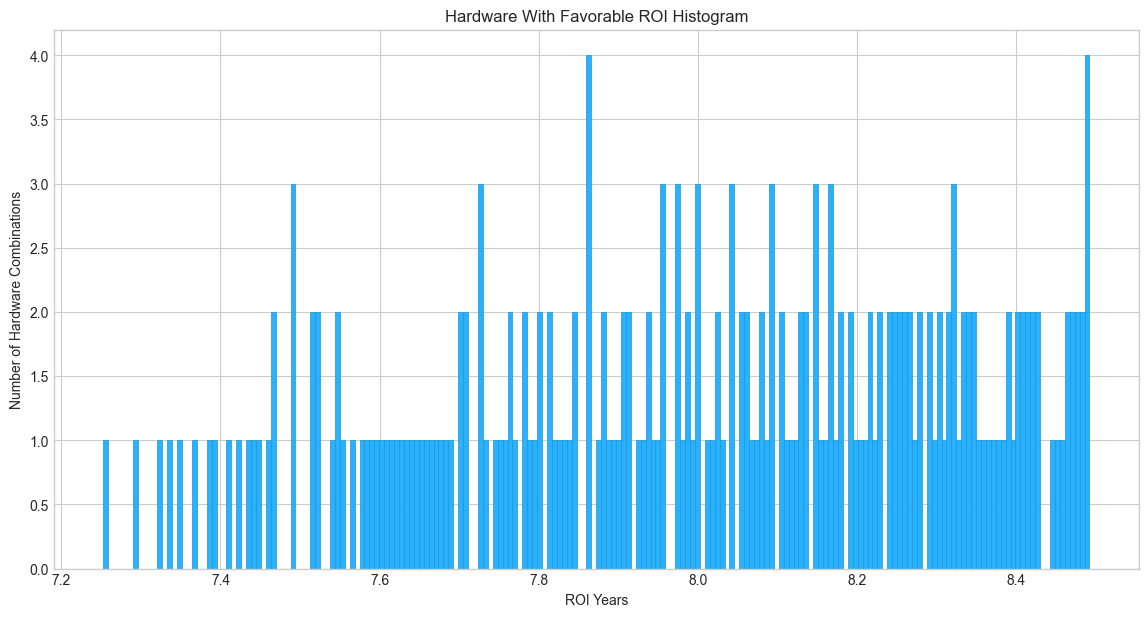

In [588]:
favROI_df = df[df['roi'] <= eol] 

print(str(favROI_df.shape[0])+ ' hardware combinations with favorable ROI')

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

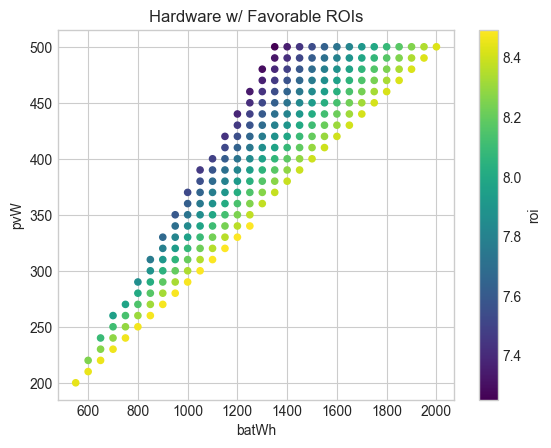

In [589]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis', title='Hardware w/ Favorable ROIs')

#df.show()

# df.savefig('foo.png')

# Results

### Most Favorable ROI

In [590]:
#most favorable ROI
favROI_df[favROI_df['roi'] == min(favROI_df['roi'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
689,500,1350,1915.40865,717.87956,646.091604,506.017147,99,264.101055,7.25256,173.017969,18.216617,91.083086


### PV System Range

In [591]:
#smallest PV system
favROI_df[favROI_df['pvW'] == min(favROI_df['pvW'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
116,200,550,895.080533,287.151824,258.436642,204.206859,245,105.964422,8.446991,69.207188,7.351447,36.757235


In [592]:
#largest PV systems
largePV = favROI_df[favROI_df['pvW'] == max(favROI_df['pvW'])] 
largePV

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
689,500,1350,1915.408650,717.87956,646.091604,506.017147,99,264.101055,7.252560,173.017969,18.216617,91.083086
739,500,1400,1952.929158,717.87956,646.091604,515.017147,98,265.721055,7.349546,173.017969,18.540617,92.703086
789,500,1450,1990.449665,717.87956,646.091604,524.017147,96,267.341055,7.445357,173.017969,18.864617,94.323086
839,500,1500,2027.970172,717.87956,646.091604,533.017147,94,268.961055,7.540014,173.017969,19.188617,95.943086
889,500,1550,2065.490680,717.87956,646.091604,542.017147,93,270.581055,7.633538,173.017969,19.512617,97.563086
939,500,1600,2103.011187,717.87956,646.091604,551.017147,91,272.201055,7.725948,173.017969,19.836617,99.183086
989,500,1650,2140.531694,717.87956,646.091604,560.017147,90,273.821055,7.817265,173.017969,20.160617,100.803086
1039,500,1700,2178.052202,717.87956,646.091604,569.017147,88,275.441055,7.907507,173.017969,20.484617,102.423086
1089,500,1750,2215.572709,717.87956,646.091604,578.017147,87,277.061055,7.996695,173.017969,20.808617,104.043086
1139,500,1800,2253.093216,717.87956,646.091604,587.017147,86,278.681055,8.084845,173.017969,21.132617,105.663086


###  Battery System Range

In [593]:
#smallest Bat system
favROI_df[favROI_df['batWh'] == min(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
116,200,550,895.080533,287.151824,258.436642,204.206859,245,105.964422,8.446991,69.207188,7.351447,36.757235


In [594]:
#larget bat systems
favROI_df[favROI_df['batWh'] == max(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2403.175246,717.87956,646.091604,623.017147,81,285.161055,8.427431,173.017969,22.428617,112.143086


### Largest System

In [595]:
#largest overall system
largestSystem = largePV[largePV['batWh'] == max(largePV['batWh'])] 
largestSystem

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2403.175246,717.87956,646.091604,623.017147,81,285.161055,8.427431,173.017969,22.428617,112.143086


### Upfront Costs

In [596]:
#cheapest upfront cost
favROI_df[favROI_df['hardwareDollars'] == min(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
116,200,550,895.080533,287.151824,258.436642,204.206859,245,105.964422,8.446991,69.207188,7.351447,36.757235


In [597]:
#most expensive upfront cost
favROI_df[favROI_df['hardwareDollars'] == max(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2403.175246,717.87956,646.091604,623.017147,81,285.161055,8.427431,173.017969,22.428617,112.143086


### DR Impact

In [598]:
#best automated DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == max(favROI_df['maxAutoParticipation'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1339,500,2000,2403.175246,717.87956,646.091604,623.017147,81,285.161055,8.427431,173.017969,22.428617,112.143086


In [599]:
#worst DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 


,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
116,200,550,895.080533,287.151824,258.436642,204.206859,245,105.964422,8.446991,69.207188,7.351447,36.757235


In [600]:
#ratio of DR income to avoided electricity costs
incRatio = favROI_df['drIncAnn']/ favROI_df['avoidedGridCosts']

print('Ratio of financial benefit sources (DR income / avoided grid costs )')
print('The higher the number, the greater the share DR income played in reaching the ROI. This is important for aligning personal incentives with grid needs')
print('Min: ' + str(min(incRatio)))
print('Max: ' + str(max(incRatio)))

      #how many DR participants are required to meet the minimum requirements?

Ratio of financial benefit sources (DR income / avoided grid costs )
The higher the number, the greater the share DR income played in reaching the ROI. This is important for aligning personal incentives with grid needs
Min: 0.5257169044327794
Max: 0.6481586109459898


### Greatest Income after ROI is reached up to EOL

In [601]:
# income from ROI to EOL 
# iar = income after return

       
print("Avg Cycles in Years: " + str(eol))
print('')

favROI_df['iar'] = (eol - favROI_df['roi']) * favROI_df['annualIncome']

print(max(favROI_df['iar']))

favROI_df[favROI_df['iar'] == max(favROI_df['iar'])] 


minIar = round(min(favROI_df['iar'])*100)*.01
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(favROI_df['iar'])*100)*.01
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")


Avg Cycles in Years: 8.493150684931507

327.64141011031643
Minimum IAR: $0.27 ($0.027000000000000003/yr for 10 years)
Maximum IAR: $327.64 ($32.763999999999996/yr for 10 years)


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Applying Existing Hardware to Model

In [610]:
# Get ROI for all hardware listed

#loop through all products

#get upfront costs w/ modules

rData = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[],
    'Cycles':[]
}
    
#loop through all batteries in database
for b in range(hardware_df.shape[0]):
    
    d = hardware_df.iloc[b]
    
    #pv watts loop 50-500 incrementing by 10
    for pW in range(50,min(500,math.floor(d['Max PV Watt']))+10,10):
        
        bWh = d['Battery Wh']
        
        #PV Watts
        rData['pvW'].append(pW)
        #Battery Watt Hours
        rData['batWh'].append(bWh)
        #Hardware Costs in Dollars
        hC = hardwareCostsFixedBattery(pW) + d['Retail Price (11/12/2023)']
        rData['hardwareDollars'].append(hC)
        #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
        pvDCkWh = dcOutputFactors * .001 * pW
        rData['annualPVkWh'].append(pvDCkWh)
        #Annual PV generation converted to AC
        pvACkWh = pvDCkWh * inverterEfficiency
        rData['annualPVkWhAC'].append(pvACkWh)
        #total annual avoided grid consumption i.e. AC solar generation
        avoidedCosts = avoidedUtilityCosts(pvACkWh)
        rData['avoidedGridCosts'].append(avoidedCosts)
        # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  
        maxParW = maxDRParticipation(bWh,pW)
        rData['maxAutoParticipation'].append(maxParW)
        # minimum participants in aggregation if using homogenous systems
        rData['minParticipants'].append(math.ceil(50000 / maxParW))
        #monthly income from DR participation
        drInc = (maxParW* 0.001 * totDRratePerkW)
        rData['drInc'].append(drInc)
        #annual income from DR participation
        rData['drIncAnn'].append(drInc * 5)
        #annual income
        inc = avoidedCosts + (drInc * 5)
        rData['annualIncome'].append(inc)
        rData['roi'].append(hC/inc)
        rData['Cycles'].append(d['Cycles'])

#load data into a DataFrame object:
productTest_df = pd.DataFrame(rData)

print(str(productTest_df.shape[0])+ ' total hardware combinations generated')

print(productTest_df.head())

1090 total hardware combinations generated
   pvW    batWh  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   50  1264.64           1079.0    71.787956      64.609160   
1   60  1264.64           1093.0    86.145547      77.530992   
2   70  1264.64           1107.0   100.503138      90.452825   
3   80  1264.64           1121.0   114.860730     103.374657   
4   90  1264.64           1135.0   129.218321     116.296489   

   maxAutoParticipation  minParticipants  annualIncome        roi  \
0            253.936915              197     63.010442  17.124146   
1            259.197258              193     67.417663  16.212369   
2            264.457601              190     71.824884  15.412486   
3            269.717944              186     76.232105  14.705090   
4            274.978286              182     80.639326  14.075018   

   avoidedGridCosts     drInc   drIncAnn  Cycles  
0         17.301797  9.141729  45.708645    4000  
1         20.762156  9.331101  46.655506    4000  
2   

In [621]:
# I think adding in cycles broke it...

favROI_products_df = productTest_df[productTest_df['roi'] <= (productTest_df['Cycles']/365)] 
favROI_products_df

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn,Cycles
12,170,1264.64,1247.0,244.079050,219.671145,317.061030,158,115.897095,10.759545,58.826109,11.414197,57.070985,4000
13,180,1264.64,1261.0,258.436642,232.592977,322.321373,156,120.304316,10.481752,62.286469,11.603569,58.017847,4000
14,190,1264.64,1275.0,272.794233,245.514810,327.581716,153,124.711537,10.223593,65.746828,11.792942,58.964709,4000
15,200,1264.64,1289.0,287.151824,258.436642,332.842059,151,129.118758,9.983058,69.207188,11.982314,59.911571,4000
16,210,1264.64,1303.0,301.509415,271.358474,338.102402,148,133.525979,9.758401,72.667547,12.171686,60.858432,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,500,1382.00,1909.0,717.879560,646.091604,511.777147,98,265.137855,7.200028,173.017969,18.423977,92.119886,3000
1086,210,538.00,903.0,301.509415,271.358474,207.307202,242,109.982843,8.210371,72.667547,7.463059,37.315296,3000
1087,220,538.00,917.0,315.867006,284.280306,212.567545,236,114.390064,8.016430,76.127906,7.652432,38.262158,3000
1088,230,538.00,931.0,330.224598,297.202138,217.827888,230,118.797286,7.836879,79.588266,7.841804,39.209020,3000


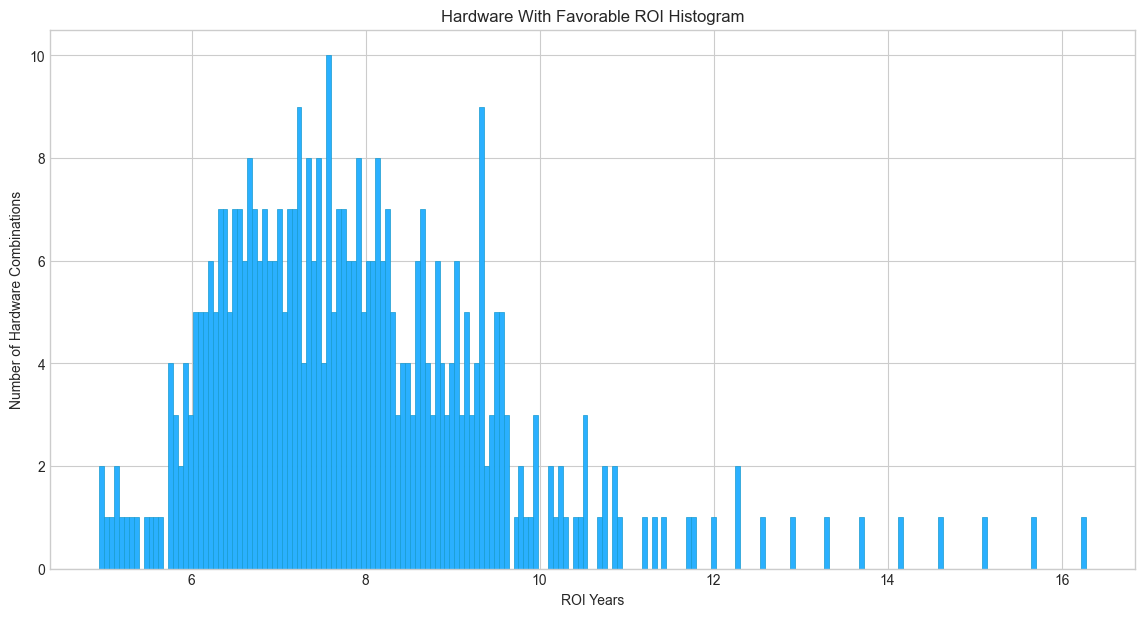

In [622]:

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_products_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

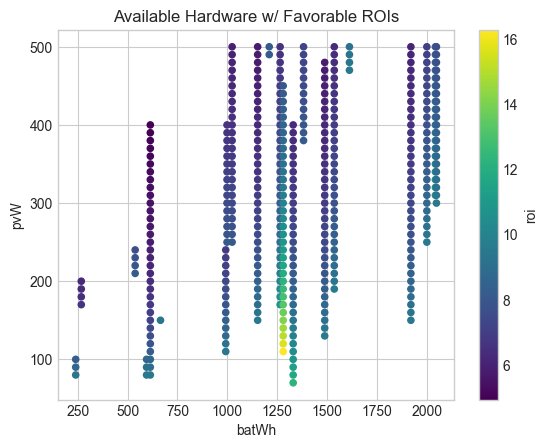

In [623]:
favROI_products_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


In [624]:
# income from ROI to EOL 
# iar = income after return
#print(favROI_products_df['Cycles']/365)

favROI_products_df['iar'] = ((favROI_products_df['Cycles']/365) - favROI_products_df['roi']) * favROI_products_df['annualIncome']

print(max(favROI_products_df['iar']))

favROI_products_df[favROI_products_df['iar'] == max(favROI_products_df['iar'])] 


minIar = round(min(favROI_products_df['iar'])*100)*.01
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(favROI_products_df['iar'])*100)*.01
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")

2001.8676703148267
Minimum IAR: $0.6900000000000001 ($0.069/yr for 10 years)
Maximum IAR: $2001.8700000000001 ($200.187/yr for 10 years)


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Discussion

Operational costs may be able to be met from the DR income after ROI has been reached

* What is the income from the point of ROI to end of life?

In [607]:
# Notes

looks at micro adjustments - exactly because of small amounts of energy

software diagram!

battery stuff for Koushick

value of resiliency? 

SyntaxError: invalid syntax (539148002.py, line 3)